In [6]:
!pip install pandas
!pip install torch
!pip install torchvision
!pip install qiskit

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [8]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])
    
simulator = qiskit.Aer.get_backend('qasm_simulator')
circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

Expected value for rotation pi 0.56


┌───┐ ░ ┌───────────┐ ░ ┌─┐
     q: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0

In [9]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [10]:
children = pd.read_csv('encoded.csv')
children = children.drop(axis=1, columns=['Unnamed: 0'])
children.head()

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,gender,jundice,Class/ASD,autism
0,1,1,0,0,1,1,0,1,0,0,0,0,0,0
1,1,1,0,0,1,1,0,1,0,0,0,0,0,0
2,1,1,0,0,0,1,1,1,0,0,0,0,0,0
3,0,1,0,0,1,1,0,0,0,1,1,1,0,0
4,1,1,1,1,1,1,1,1,1,1,0,1,1,0


In [12]:
adult = pd.read_csv('EncodedAdolescent.csv')
adult = adult.drop(axis=1, columns=['id'])
adult.rename(columns={"austim": "autism"}, inplace=True)
adult.head()

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,gender,jundice,Class/ASD,autism
0,0,0,0,1,1,1,1,1,1,0,0,1,0,1
1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1,1,1,0,0,0
3,0,1,1,1,1,1,0,1,1,0,1,0,1,0
4,1,1,1,1,1,1,1,0,0,0,1,0,1,0


In [13]:
data = pd.concat([children, adult])
print(data.shape)
data.head()

(396, 14)


,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,gender,jundice,Class/ASD,autism
0,1,1,0,0,1,1,0,1,0,0,0,0,0,0
1,1,1,0,0,1,1,0,1,0,0,0,0,0,0
2,1,1,0,0,0,1,1,1,0,0,0,0,0,0
3,0,1,0,0,1,1,0,0,0,1,1,1,0,0
4,1,1,1,1,1,1,1,1,1,1,0,1,1,0


In [14]:
def partition(data, n):
    """Randomly partitions the data into n non-overlapping parts
    Args:
        data: dataframe object, the dataset to partition
        n: number of equal parts to split the data
    Returns:
        splits: list of n parts of the data, each one is a dataframe
    """
    splits = []
    remaining = data.copy(deep=True)
    for i in range(n):
        split = remaining.sample(frac=1/(n-i), random_state=10)
        splits.append(split)
        remaining = remaining.drop(split.index)
    return splits

# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [15]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None, target_transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        # self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(13, 13)
        self.fc2 = nn.Linear(13, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        # x = F.relu(self.conv1(x))
        # x = F.max_pool2d(x, 2)
        # x = F.relu(self.conv2(x))
        # x = F.max_pool2d(x, 2)
        # x = self.dropout(x)
        # x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [17]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()
epochs = 20
model.train()

Net(
  (fc1): Linear(in_features=13, out_features=13, bias=True)
  (fc2): Linear(in_features=13, out_features=1, bias=True)
  (hybrid): Hybrid()
)

In [18]:
def train_model(model, optimizer, epochs, train_loader, test_loader):
    train_loss_list = []
    for epoch in range(epochs):
        losses = []
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            # Forward pass
            output = model(data)
            # Calculate loss
            loss = loss_func(output, target)
            # Backward pass
            loss.backward()
            # Optimize weights
            optimizer.step()
            losses.append(loss.item())
        train_loss_list.append(sum(losses)/len(losses))
        print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, train_loss_list[-1]))
        
    model.eval()
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        losses = []
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target)
            losses.append(loss.item())

        print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
            sum(losses) / len(losses),
            correct / len(test_loader) * 100)
            )
        test_loss = sum(losses) / len(losses)
        accuracy = correct / len(test_loader) * 100
    return train_loss_list, test_loss, accuracy

In [19]:
def cross_val(model, data, n, optimizer, loss_func, epochs):
    """n-fold cross validation for a model
    Args:
        model: the estimator to train and validate
        data: dataframe object, the complete dataset
              it is assumed that the dataset contains the labels
        n: number of folds to conduct cross validation
        target: a string corresponding to the column that serves as labels
    
    Returns:
        scores: list of n elements corresponding to accuracy scores in each fold
    """
    all_accuracy = []
    all_train_loss = []
    all_test_loss = []
    splits = partition(data, n)
    for i in range(n):
        train_list = splits[:i] + splits[i+1:]
        train = pd.concat(train_list)
        test = splits[i]
        
        X_train = train.drop(axis=1, columns=['autism'])
        X_train_series_list = []
        for _, row in X_train.iterrows():
            tensor_from_series = df_to_tensor(row)
            X_train_series_list.append(tensor_from_series)
        X_train_tensor = torch.stack(X_train_series_list)
        
        Y_train = train.autism.astype('int64')
        Y_train_tensor = df_to_tensor(Y_train)
        Y_train_tensor = Y_train_tensor.type(torch.int64)
        
        train_data = CustomDataset(data=X_train_tensor, targets=Y_train_tensor)
        
        X_test = test.drop(axis=1, columns=['autism'])
        X_test_series_list = []
        for _, row in X_test.iterrows():
            tensor_from_series = df_to_tensor(row)
            X_test_series_list.append(tensor_from_series)
        X_test_tensor = torch.stack(X_test_series_list)
        
        Y_test = test.autism.astype('int64')
        Y_test_tensor = df_to_tensor(Y_test)
        Y_test_tensor = Y_test_tensor.type(torch.int64)
        
        test_data = CustomDataset(data=X_test_tensor, targets=Y_test_tensor)
        
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
        
        print(f"Cross validation at fold #{i+1}")
        print(f"Train: {len(X_train)} samples, test: {len(X_test)} samples")
        train_loss_list, test_loss, accuracy = train_model(model, optimizer, epochs, train_loader, test_loader)
        all_accuracy.append(accuracy)
        print(f"Length of all_accuracy: {len(all_accuracy)}")
        all_train_loss.append(train_loss_list)
        print(f"Length of all_train_loss: {len(all_train_loss)}")
        all_test_loss.append(test_loss)
        print(f"Length of all_test_loss: {len(all_test_loss)}")
        print()
        
    return all_accuracy, all_train_loss, all_test_loss

In [20]:
all_accuracy, all_train_loss, all_test_loss = cross_val(model, data, 10, optimizer, loss_func, epochs)

Cross validation at fold #1
Train: 264 samples, test: 40 samples


/tmp/ipykernel_467/2571825612.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  result = torch.tensor([expectation_z])
/tmp/ipykernel_467/2571825612.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.6966
Training [10%]	Loss: -0.7886
Training [15%]	Loss: -0.7962
Training [20%]	Loss: -0.7995
Training [25%]	Loss: -0.8061
Training [30%]	Loss: -0.8072
Training [35%]	Loss: -0.8108
Training [40%]	Loss: -0.8118
Training [45%]	Loss: -0.8110
Training [50%]	Loss: -0.8128
Training [55%]	Loss: -0.8133
Training [60%]	Loss: -0.8131
Training [65%]	Loss: -0.8139
Training [70%]	Loss: -0.8145
Training [75%]	Loss: -0.8148
Training [80%]	Loss: -0.8148
Training [85%]	Loss: -0.8150
Training [90%]	Loss: -0.8155
Training [95%]	Loss: -0.8174
Training [100%]	Loss: -0.8165
Performance on test data:
	Loss: -0.8610
	Accuracy: 87.5%
Length of all_accuracy: 1
Length of all_train_loss: 1
Length of all_test_loss: 1

Cross validation at fold #2
Train: 267 samples, test: 37 samples


/tmp/ipykernel_467/2571825612.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.8205
Training [10%]	Loss: -0.8199
Training [15%]	Loss: -0.8209
Training [20%]	Loss: -0.8227
Training [25%]	Loss: -0.8224
Training [30%]	Loss: -0.8221
Training [35%]	Loss: -0.8228
Training [40%]	Loss: -0.8242
Training [45%]	Loss: -0.8253
Training [50%]	Loss: -0.8253
Training [55%]	Loss: -0.8252
Training [60%]	Loss: -0.8281
Training [65%]	Loss: -0.8274
Training [70%]	Loss: -0.8275
Training [75%]	Loss: -0.8296
Training [80%]	Loss: -0.8293
Training [85%]	Loss: -0.8301
Training [90%]	Loss: -0.8301
Training [95%]	Loss: -0.8301
Training [100%]	Loss: -0.8307
Performance on test data:
	Loss: -0.8365
	Accuracy: 83.8%
Length of all_accuracy: 2
Length of all_train_loss: 2
Length of all_test_loss: 2

Cross validation at fold #3
Train: 268 samples, test: 36 samples


/tmp/ipykernel_467/2571825612.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.8190
Training [10%]	Loss: -0.8199
Training [15%]	Loss: -0.8207
Training [20%]	Loss: -0.8202
Training [25%]	Loss: -0.8228
Training [30%]	Loss: -0.8224
Training [35%]	Loss: -0.8224
Training [40%]	Loss: -0.8225
Training [45%]	Loss: -0.8238
Training [50%]	Loss: -0.8230
Training [55%]	Loss: -0.8228
Training [60%]	Loss: -0.8239
Training [65%]	Loss: -0.8237
Training [70%]	Loss: -0.8256
Training [75%]	Loss: -0.8274
Training [80%]	Loss: -0.8268
Training [85%]	Loss: -0.8272
Training [90%]	Loss: -0.8270
Training [95%]	Loss: -0.8274
Training [100%]	Loss: -0.8277
Performance on test data:
	Loss: -0.9256
	Accuracy: 91.7%
Length of all_accuracy: 3
Length of all_train_loss: 3
Length of all_test_loss: 3

Cross validation at fold #4
Train: 271 samples, test: 33 samples


/tmp/ipykernel_467/2571825612.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.8354
Training [10%]	Loss: -0.8342
Training [15%]	Loss: -0.8380
Training [20%]	Loss: -0.8377
Training [25%]	Loss: -0.8383
Training [30%]	Loss: -0.8389
Training [35%]	Loss: -0.8387
Training [40%]	Loss: -0.8398
Training [45%]	Loss: -0.8398
Training [50%]	Loss: -0.8419
Training [55%]	Loss: -0.8415
Training [60%]	Loss: -0.8421
Training [65%]	Loss: -0.8413
Training [70%]	Loss: -0.8436
Training [75%]	Loss: -0.8408
Training [80%]	Loss: -0.8440
Training [85%]	Loss: -0.8431
Training [90%]	Loss: -0.8446
Training [95%]	Loss: -0.8436
Training [100%]	Loss: -0.8458
Performance on test data:
	Loss: -0.8558
	Accuracy: 84.8%
Length of all_accuracy: 4
Length of all_train_loss: 4
Length of all_test_loss: 4

Cross validation at fold #5
Train: 273 samples, test: 31 samples


/tmp/ipykernel_467/2571825612.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.8539
Training [10%]	Loss: -0.8527
Training [15%]	Loss: -0.8548
Training [20%]	Loss: -0.8543
Training [25%]	Loss: -0.8556
Training [30%]	Loss: -0.8560
Training [35%]	Loss: -0.8560
Training [40%]	Loss: -0.8565
Training [45%]	Loss: -0.8556
Training [50%]	Loss: -0.8584
Training [55%]	Loss: -0.8566
Training [60%]	Loss: -0.8578
Training [65%]	Loss: -0.8577
Training [70%]	Loss: -0.8575
Training [75%]	Loss: -0.8578
Training [80%]	Loss: -0.8603
Training [85%]	Loss: -0.8596
Training [90%]	Loss: -0.8607
Training [95%]	Loss: -0.8606
Training [100%]	Loss: -0.8599
Performance on test data:
	Loss: -0.7790
	Accuracy: 80.6%
Length of all_accuracy: 5
Length of all_train_loss: 5
Length of all_test_loss: 5

Cross validation at fold #6
Train: 274 samples, test: 30 samples


/tmp/ipykernel_467/2571825612.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.8682
Training [10%]	Loss: -0.8693
Training [15%]	Loss: -0.8689
Training [20%]	Loss: -0.8707
Training [25%]	Loss: -0.8696
Training [30%]	Loss: -0.8695
Training [35%]	Loss: -0.8706
Training [40%]	Loss: -0.8715
Training [45%]	Loss: -0.8703
Training [50%]	Loss: -0.8729
Training [55%]	Loss: -0.8718
Training [60%]	Loss: -0.8718
Training [65%]	Loss: -0.8721
Training [70%]	Loss: -0.8730
Training [75%]	Loss: -0.8739
Training [80%]	Loss: -0.8714
Training [85%]	Loss: -0.8724
Training [90%]	Loss: -0.8728
Training [95%]	Loss: -0.8737
Training [100%]	Loss: -0.8734
Performance on test data:
	Loss: -0.6437
	Accuracy: 66.7%
Length of all_accuracy: 6
Length of all_train_loss: 6
Length of all_test_loss: 6

Cross validation at fold #7
Train: 276 samples, test: 28 samples


/tmp/ipykernel_467/2571825612.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.8485
Training [10%]	Loss: -0.8484
Training [15%]	Loss: -0.8491
Training [20%]	Loss: -0.8466
Training [25%]	Loss: -0.8499
Training [30%]	Loss: -0.8504
Training [35%]	Loss: -0.8482
Training [40%]	Loss: -0.8488
Training [45%]	Loss: -0.8529
Training [50%]	Loss: -0.8489
Training [55%]	Loss: -0.8521
Training [60%]	Loss: -0.8512
Training [65%]	Loss: -0.8524
Training [70%]	Loss: -0.8493
Training [75%]	Loss: -0.8518
Training [80%]	Loss: -0.8524
Training [85%]	Loss: -0.8534
Training [90%]	Loss: -0.8522
Training [95%]	Loss: -0.8508
Training [100%]	Loss: -0.8525
Performance on test data:
	Loss: -0.8939
	Accuracy: 89.3%
Length of all_accuracy: 7
Length of all_train_loss: 7
Length of all_test_loss: 7

Cross validation at fold #8
Train: 279 samples, test: 25 samples


/tmp/ipykernel_467/2571825612.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.8622
Training [10%]	Loss: -0.8635
Training [15%]	Loss: -0.8613
Training [20%]	Loss: -0.8658
Training [25%]	Loss: -0.8653
Training [30%]	Loss: -0.8641
Training [35%]	Loss: -0.8647
Training [40%]	Loss: -0.8638
Training [45%]	Loss: -0.8643
Training [50%]	Loss: -0.8627
Training [55%]	Loss: -0.8648
Training [60%]	Loss: -0.8652
Training [65%]	Loss: -0.8661
Training [70%]	Loss: -0.8665
Training [75%]	Loss: -0.8672
Training [80%]	Loss: -0.8639
Training [85%]	Loss: -0.8641
Training [90%]	Loss: -0.8655
Training [95%]	Loss: -0.8655
Training [100%]	Loss: -0.8682
Performance on test data:
	Loss: -0.7556
	Accuracy: 80.0%
Length of all_accuracy: 8
Length of all_train_loss: 8
Length of all_test_loss: 8

Cross validation at fold #9
Train: 281 samples, test: 23 samples


/tmp/ipykernel_467/2571825612.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.8662
Training [10%]	Loss: -0.8668
Training [15%]	Loss: -0.8672
Training [20%]	Loss: -0.8677
Training [25%]	Loss: -0.8666
Training [30%]	Loss: -0.8663
Training [35%]	Loss: -0.8672
Training [40%]	Loss: -0.8666
Training [45%]	Loss: -0.8682
Training [50%]	Loss: -0.8686
Training [55%]	Loss: -0.8678
Training [60%]	Loss: -0.8681
Training [65%]	Loss: -0.8672
Training [70%]	Loss: -0.8676
Training [75%]	Loss: -0.8684
Training [80%]	Loss: -0.8681
Training [85%]	Loss: -0.8678
Training [90%]	Loss: -0.8684
Training [95%]	Loss: -0.8691
Training [100%]	Loss: -0.8712
Performance on test data:
	Loss: -0.7474
	Accuracy: 78.3%
Length of all_accuracy: 9
Length of all_train_loss: 9
Length of all_test_loss: 9

Cross validation at fold #10
Train: 283 samples, test: 21 samples


/tmp/ipykernel_467/2571825612.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.8510
Training [10%]	Loss: -0.8525
Training [15%]	Loss: -0.8525
Training [20%]	Loss: -0.8507
Training [25%]	Loss: -0.8524
Training [30%]	Loss: -0.8526
Training [35%]	Loss: -0.8539
Training [40%]	Loss: -0.8552
Training [45%]	Loss: -0.8519
Training [50%]	Loss: -0.8539
Training [55%]	Loss: -0.8536
Training [60%]	Loss: -0.8543
Training [65%]	Loss: -0.8560
Training [70%]	Loss: -0.8563
Training [75%]	Loss: -0.8568
Training [80%]	Loss: -0.8568
Training [85%]	Loss: -0.8535
Training [90%]	Loss: -0.8550
Training [95%]	Loss: -0.8546
Training [100%]	Loss: -0.8549
Performance on test data:
	Loss: -0.9348
	Accuracy: 95.2%
Length of all_accuracy: 10
Length of all_train_loss: 10
Length of all_test_loss: 10



In [21]:
# Avg accuracy
sum(all_accuracy) / len(all_accuracy)

83.78954423449514

In [22]:
# Avg test loss
sum(all_test_loss) / len(all_test_loss)

-0.8233180323069103

Text(0, 0.5, '%')

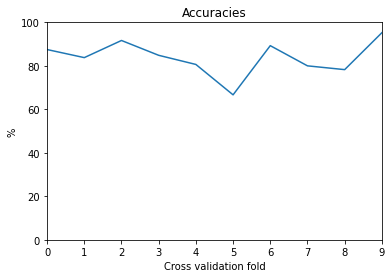

In [23]:
ax = plt.gca()
ax.set_xlim([0, 9])
ax.set_ylim([0, 100])

plt.plot(all_accuracy)
plt.title('Accuracies')
plt.xlabel('Cross validation fold')
plt.ylabel('%')